# MIRA: Final Project 2023
Professor: Josep Quintana, Robert Martí

Topic: Image registration of chest CT volumes: 4DCT DIR-Lab Challenge

Taiabur


In [1]:
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import nibabel as nib
from typing import Tuple
from pathlib import Path
import cv2
from scipy import ndimage as ndi

from utils.preprocessing import image_segmentation, generate_mask, multiplied, apply_clahe
from utils.visualize import display_images_two_column

/var/folders/zp/kn2c7zks0q55p6_3s3c4b97h0000gn/T/ipykernel_29938/1534019213.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


image registration

In [2]:

MAIN_PATH       = Path('./').resolve()
TRAIN_DATA_PATH = MAIN_PATH / 'dataset' / 'train'
OUTPUT_DATA_PATH = MAIN_PATH / 'dataset' / 'output'
OUTPUT_PP_DATA_PATH = MAIN_PATH / 'dataset' / 'preprocessing_output'
SEGMENTED_DATA_PATH = OUTPUT_PP_DATA_PATH / 'segmented_image'


In [3]:


for i, dir in enumerate(TRAIN_DATA_PATH.iterdir()):
    # Skip .DS_Store
    if dir.name == '.DS_Store':
        continue
    id = dir.stem

    inhale_name = f'{id}_iBHCT.nii.gz'
    exhale_name = f'{id}_eBHCT.nii.gz'

    inhale_image_path   = dir / inhale_name
    exhale_image_path   = dir / exhale_name

    segmentation_image_save_path = SEGMENTED_DATA_PATH / id 

    # Check if the directory exists. If not, create it.
    if not segmentation_image_save_path.exists():
        os.makedirs(segmentation_image_save_path)
    
    remove_gantry_path = SEGMENTED_DATA_PATH / id 

    image_segmentation(inhale_image_path, segmentation_image_save_path / inhale_name, remove_gantry_path / f'rg_{inhale_name}', remove_gantry_path / f'rg_mask_{inhale_name}')
    image_segmentation(exhale_image_path, segmentation_image_save_path / exhale_name, remove_gantry_path / f'rg_{exhale_name}', remove_gantry_path / f'rg_mask_{exhale_name}')


In [4]:
segmented_image = OUTPUT_PP_DATA_PATH / 'segmented_image'

for i, dir in enumerate(segmented_image.iterdir()):
    # Skip .DS_Store
    if dir.name == '.DS_Store':
        continue
    id = dir.stem
    if i < 5:
        inhale_name = f'{id}_iBHCT.nii.gz'
        exhale_name = f'{id}_eBHCT.nii.gz'

        inhale_image_path   = dir / inhale_name
        exhale_image_path   = dir / exhale_name
        
        inhale_rg_image_path   = dir / f'rg_{id}_iBHCT.nii.gz'
        exhale_rg_image_path   = dir / f'rg_{id}_eBHCT.nii.gz'
        
        _segmentation_image_save_path = segmented_image / id 
        
        # Check if the directory exists. If not, create it.
        if not _segmentation_image_save_path.exists():
            os.makedirs(_segmentation_image_save_path)
        
        clahe_image_save_path = OUTPUT_PP_DATA_PATH / 'clahe' / id

        if not clahe_image_save_path.exists():
            os.makedirs(clahe_image_save_path)

        # print(inhale_image_path)
        # print(exhale_image_path)

        # print(inhale_segmentation_image_save_path)
        # print(exhale_segmentation_image_save_path)
            
        # Create Mask
        i_segmented_mask = generate_mask(inhale_rg_image_path, _segmentation_image_save_path / f'mask_{inhale_name}')
        e_segmented_mask = generate_mask(exhale_rg_image_path, _segmentation_image_save_path / f'mask_{exhale_name}')

        # Multiplied with original image and mask
        multiplied(inhale_image_path, _segmentation_image_save_path / f'mask_{inhale_name}', _segmentation_image_save_path / f'multiplied_{inhale_name}')
        multiplied(exhale_image_path, _segmentation_image_save_path / f'mask_{exhale_name}', _segmentation_image_save_path / f'multiplied_{exhale_name}')

        # Apply Clahe 
        apply_clahe(_segmentation_image_save_path / f'multiplied_{inhale_name}', clahe_image_save_path / f'{inhale_name}')
        apply_clahe(_segmentation_image_save_path / f'multiplied_{exhale_name}', clahe_image_save_path / f'{exhale_name}')
    
print('Preprocessing Done')

Preprocessing Done


In [5]:

# Function to load a NIfTI file and return its data
def load_nifti(file_path):
    try:
        nifti_img = nib.load(file_path)
        return nifti_img.get_fdata()
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None


def image_histogram(_images_path):
    # Define a list of distinct colors
    colors = ['lightblue', 'red', 'salmon', 'green', 'lightgreen', 'orange', 'yellow', 'blue','olive']

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjusted figsize for better visibility
    sorted_files = sorted(_images_path.iterdir(), key=lambda x: x.name)

    # Process each image pair
    for i, dir in enumerate(sorted_files):
        if dir.name == '.DS_Store':
            continue
        id = dir.stem
        inhale_rg_image_path = dir / f'{id}_iBHCT.nii.gz'
        exhale_rg_image_path = dir / f'{id}_eBHCT.nii.gz'

        data1 = load_nifti(inhale_rg_image_path)
        data2 = load_nifti(exhale_rg_image_path)

        if data1 is not None and data2 is not None:
            # Flatten the 3D image data to 1D for histogram computation
            data1_flat = data1.flatten()
            data2_flat = data2.flatten()
            
            # Determine the maximum intensity value across both images
            max_intensity = max(data1_flat.max(), data2_flat.max())

            # Compute histograms
            hist1, bins1 = np.histogram(data1_flat, bins=256, range=[0, max_intensity])
            hist2, bins2 = np.histogram(data2_flat, bins=256, range=[0, max_intensity])
            
            color_index = i * 2
            # Plot histograms
            axes[0].plot(bins1[:-1], hist1, label=f'{id}_iBHCT', color=colors[color_index])
            axes[1].plot(bins2[:-1], hist2, label=f'{id}_eBHCT', color=colors[color_index - 1])

    # Add title, labels, and legend to the plot
    axes[0].set_title('Histogram of Image iBHCT')
    axes[0].set_xlabel('Intensity Value')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()

    axes[1].set_title('Histogram of Image eBHCT')
    axes[1].set_xlabel('Intensity Value')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()

    # Display the plot
    plt.show()


Original Image


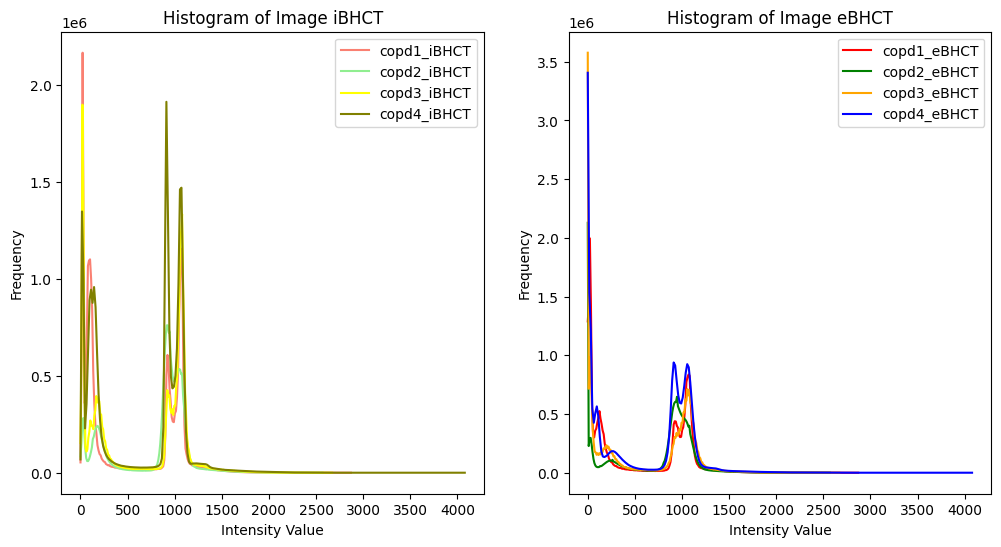

Segmented Image


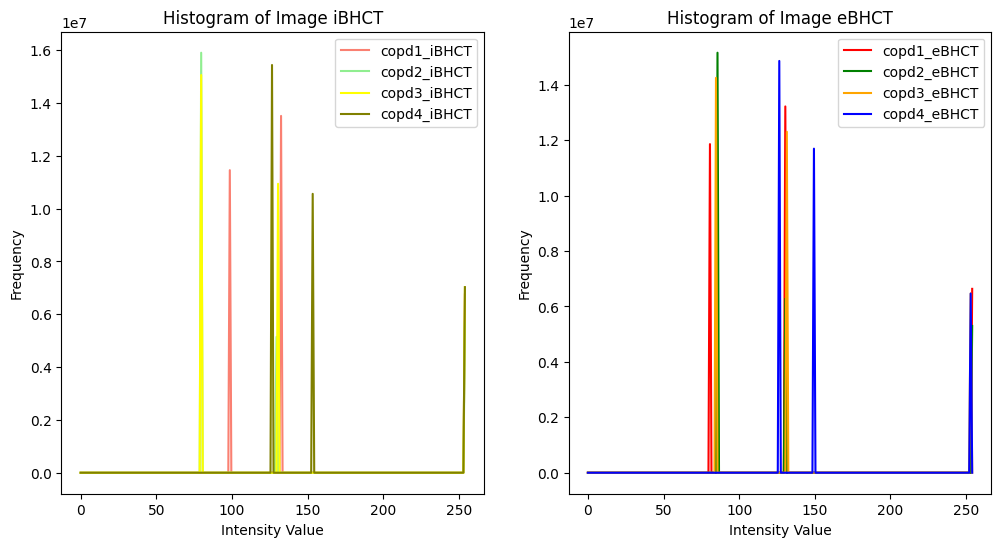

In [6]:
# Assuming SEGMENTED_DATA_PATH is defined
print("Original Image")
image_histogram(TRAIN_DATA_PATH)
print("Segmented Image")
image_histogram(SEGMENTED_DATA_PATH)

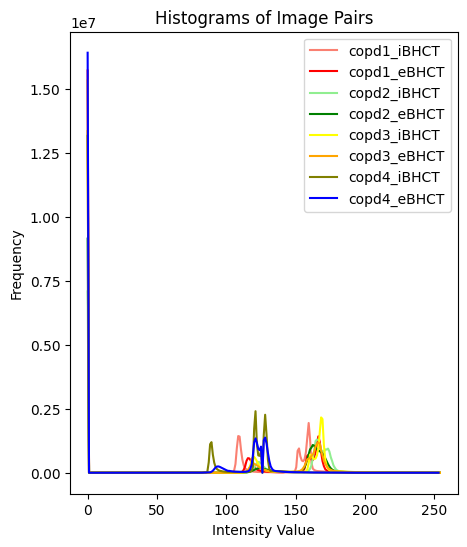

In [7]:


# Function to load a NIfTI file and return its data
def load_nifti(file_path):
    try:
        nifti_img = nib.load(file_path)
        return nifti_img.get_fdata()
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None


segmented_image = Path(SEGMENTED_DATA_PATH)

# Define a list of distinct colors
colors = [ 'lightblue', 'red', 'salmon', 'green', 'lightgreen', 'orange', 'yellow','blue','olive']

plt.figure(figsize=(5, 6))
sorted_files = sorted(segmented_image.iterdir(), key=lambda x: x.name)
# Process each image pair
for i, dir in enumerate(sorted_files):
    if dir.name == '.DS_Store':
        continue
    
    id = dir.stem
    inhale_rg_image_path = dir / f'rg_{id}_iBHCT.nii.gz'
    exhale_rg_image_path = dir / f'rg_{id}_eBHCT.nii.gz'

    data1 = load_nifti(inhale_rg_image_path)
    data2 = load_nifti(exhale_rg_image_path)

    if data1 is not None and data2 is not None:
        # Flatten the 3D image data to 1D for histogram computation
        data1_flat = data1.flatten()
        data2_flat = data2.flatten()
        
        # Determine the maximum intensity value across both images
        max_intensity = max(data1_flat.max(), data2_flat.max())

        # Compute histograms
        hist1, bins1 = np.histogram(data1_flat, bins=256, range=[0, max_intensity])
        hist2, bins2 = np.histogram(data2_flat, bins=256, range=[0, max_intensity])
        
        color_index = i * 2
        # Plot histograms
        plt.plot(bins1[:-1], hist1, label=f'{id}_iBHCT', color=colors[color_index])
        plt.plot(bins2[:-1], hist2, label=f'{id}_eBHCT', color=colors[color_index - 1])


# Add title, labels, and legend to the plot
plt.title('Histograms of Image Pairs')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()

In [8]:
def load_and_display_image(nifti_file_path, ax, slice_index=None):
    # Load the NIfTI file
    image = sitk.ReadImage(str(nifti_file_path))

    # Get the image data
    image_data = sitk.GetArrayFromImage(image)

    # If no specific slice index is given, use the middle slice
    if slice_index is None:
        slice_index = image_data.shape[0] // 2

    # Display the image in the provided axes
    ax.imshow(image_data[slice_index, :, :], cmap='gray')
    ax.set_title(f'{nifti_file_path.name}')
    ax.axis('off')


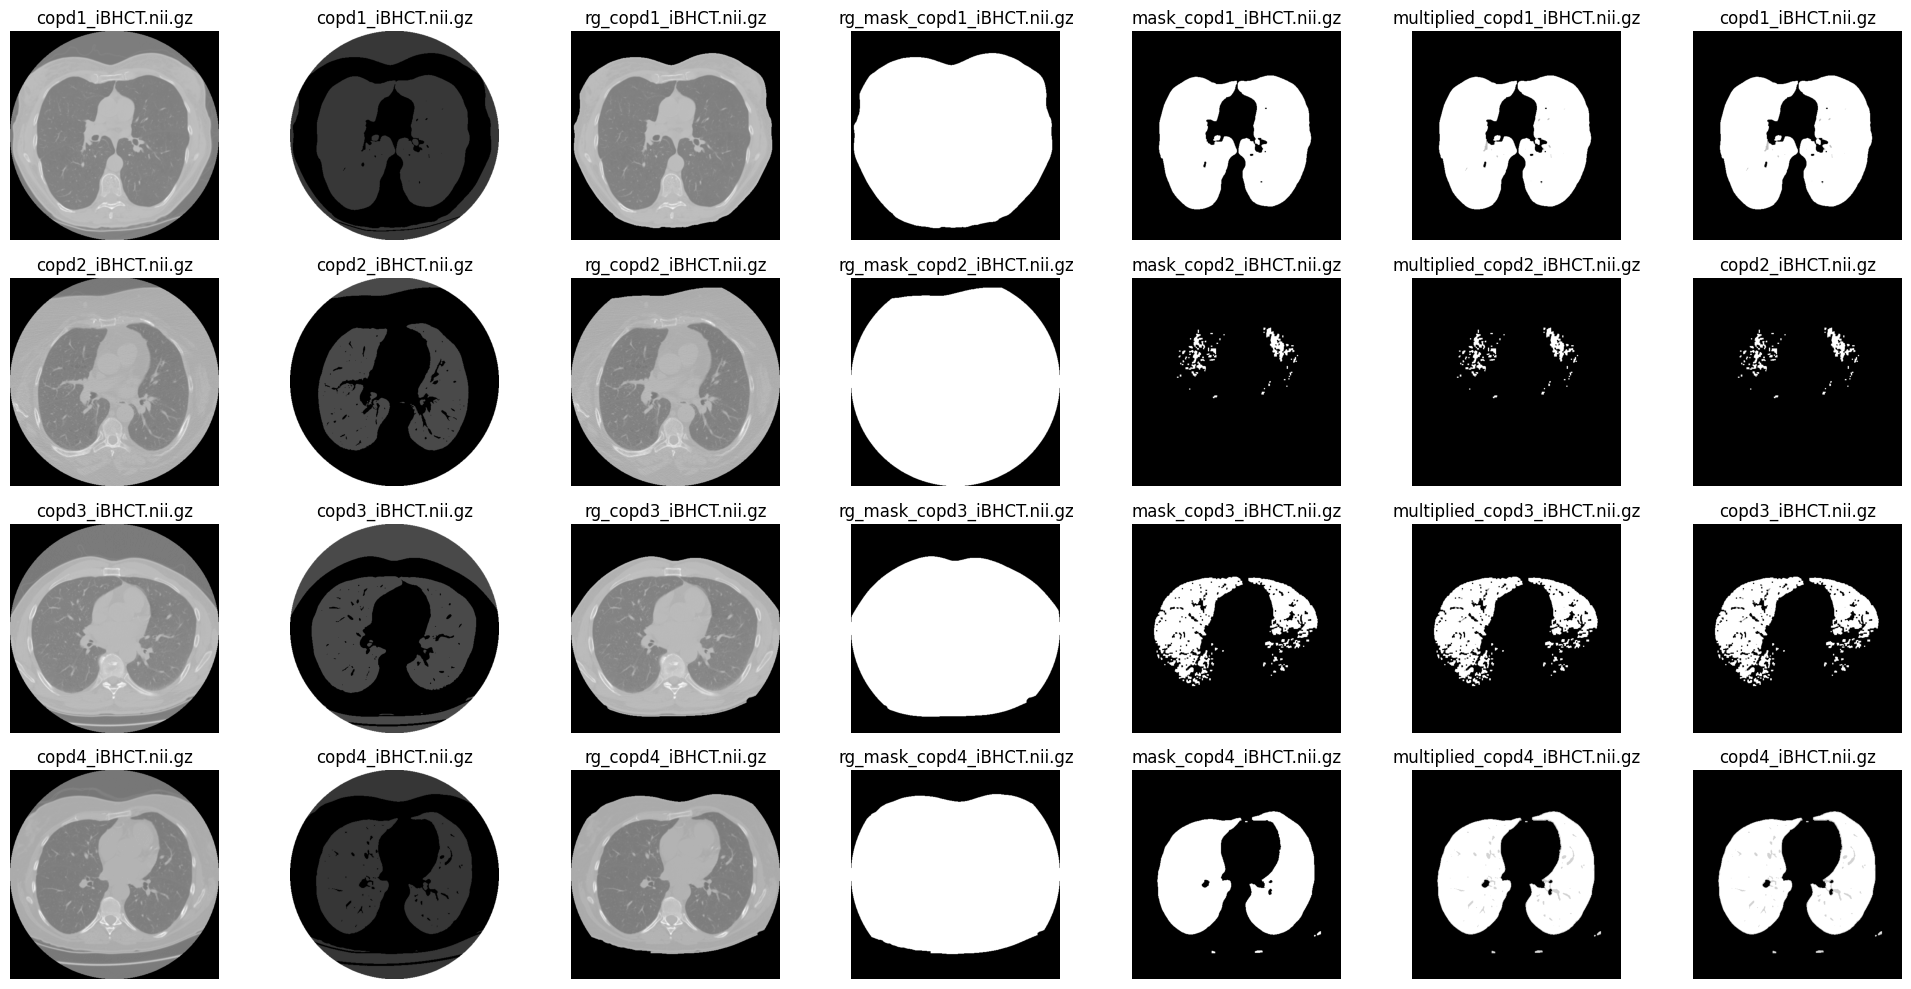

In [9]:
segmented_image = OUTPUT_PP_DATA_PATH / 'segmented_image'

# Set up the figure for subplots
fig, axs = plt.subplots(4, 7, figsize=(20, 10))  # Adjust figsize as needed
segmented_image = sorted([x for x in segmented_image.iterdir() if x.name != '.DS_Store'], key=lambda x: x.name)

for i, dir in enumerate(segmented_image):
    id = dir.stem
    if True:
        inhale_name = TRAIN_DATA_PATH / id / f'{id}_iBHCT.nii.gz'
        exhale_name = TRAIN_DATA_PATH / id / f'{id}_eBHCT.nii.gz'

        inhale_image_path   = dir / f'{id}_iBHCT.nii.gz'
        exhale_image_path   = dir / f'{id}_eBHCT.nii.gz'

        inhale_rg_path   = dir / f'rg_{id}_iBHCT.nii.gz'
        exhale_rg_path   = dir / f'rg_{id}_eBHCT.nii.gz'

        inhale_rg_mask_path   = dir / f'rg_mask_{id}_iBHCT.nii.gz'
        exhale_rg_mask_path   = dir / f'rg_mask_{id}_eBHCT.nii.gz'

        inhale_mask_path   = dir / f'mask_{id}_iBHCT.nii.gz'
        exhale_mask_path   = dir / f'mask_{id}_eBHCT.nii.gz'

        inhale_mutiplied_path   = dir / f'multiplied_{id}_iBHCT.nii.gz'
        exhale_mutiplied_path   = dir / f'multiplied_{id}_eBHCT.nii.gz'

        inhale_clahe_path   = OUTPUT_PP_DATA_PATH / 'clahe' / id / f'{id}_iBHCT.nii.gz'
        exhale_clahe_path   = OUTPUT_PP_DATA_PATH/ 'clahe' / id / f'{id}_eBHCT.nii.gz'
        # Display each type of image in a column
        load_and_display_image(inhale_name, axs[i, 0])
        load_and_display_image(inhale_image_path, axs[i, 1])
        load_and_display_image(inhale_rg_path, axs[i, 2])
        load_and_display_image(inhale_rg_mask_path, axs[i, 3])
        load_and_display_image(inhale_mask_path, axs[i, 4])
        load_and_display_image(inhale_mutiplied_path, axs[i, 5])
        load_and_display_image(inhale_clahe_path, axs[i, 6])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [10]:
import nibabel as nib
import scipy.ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist

def _generate_mask(nifti_file, visualize=True):
    # Load the NIfTI file
    image = nib.load(nifti_file)

    # Get the image data
    image_data = image.get_fdata()

    # Apply histogram equalization
    eq_image_data = equalize_hist(image_data)
    # Threshold values based on the histogram analysis
    lower_threshold = 100
    upper_threshold = 200
    # Apply threshold to create a mask: values between 150 and 255 are set to 0 (black), others are unchanged
    threshold_image = np.where((eq_image_data > lower_threshold) & (eq_image_data <= upper_threshold), 0, image_data).astype(np.uint8)

    # Morphological operations for segmentation
    struct = np.ones((3, 3, 3))
    segmented = ndi.binary_closing(threshold_image, structure=struct)
    # segmented = ndi.binary_opening(segmented, structure=struct)

    if visualize:
        # Determine the middle index of the 3rd dimension
        mid_slice = image_data.shape[2] // 2
        
        plt.figure(figsize=(20, 5))

        # Original image slice
        plt.subplot(1, 5, 1)
        plt.imshow(image_data[:, :, mid_slice], cmap='gray')
        plt.title('Original Image Slice')
        plt.axis('off')

        # Histogram of the original image slice
        plt.subplot(1, 5, 2)
        plt.hist(image_data[:, :, mid_slice].ravel(), bins=256, fc='black', ec='black')
        plt.title('Histogram of Original Image')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Count')

        # Equalized image slice
        plt.subplot(1, 5, 3)
        plt.imshow(eq_image_data[:, :, mid_slice], cmap='gray')
        plt.title('Equalized Image Slice')
        plt.axis('off')

        # Mask slice
        plt.subplot(1, 5, 4)
        plt.imshow(threshold_image[:, :, mid_slice], cmap='gray')
        plt.title('Mask Slice')
        plt.axis('off')

        # Image with Mask slice
        plt.subplot(1, 5, 5)
        plt.imshow(segmented[:, :, mid_slice], cmap='gray')
        plt.title('Segmented Image Slice')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
